In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

plt.rcParams["figure.figsize"] = (12, 4)
SEED = 42
np.random.seed(SEED)

DATA_FILE = "merged_5min_spline_interpolated.csv"
TIME_STEP_MINUTES = 5.0          
TEST_DAYS = 1                    
SAMPLES_PER_DAY = 288           
TEST_SIZE = TEST_DAYS * SAMPLES_PER_DAY

In [17]:
WINDOW_NAME = "12 hour"
WINDOW_SAMPLES = 144  #1hr=12samples

full_data = pd.read_csv(DATA_FILE)
full_data["time"] = pd.to_datetime(full_data["time"], utc=True, errors="coerce")
full_data = full_data.dropna(subset=["time"]).sort_values("time").reset_index(drop=True)
full_data = full_data.dropna(subset=["supply_air", "outdoor_temp", "satellite_value", "indoor_temp"]).reset_index(drop=True)

# Split into train and test (SAME AS OTHER MODELS)
train_data = full_data.iloc[:-TEST_SIZE].reset_index(drop=True)
test_data = full_data.iloc[-TEST_SIZE:].reset_index(drop=True)

print(f"training samples{len(train_data)}")
print(f"testing samples {len(test_data)}")


training samples15801
testing samples 288


In [18]:
def prepare_one_step_dataset(df):
    input_matrix = df[["supply_air", "outdoor_temp", "satellite_value", "indoor_temp"]].shift(1)
    input_matrix = input_matrix.iloc[1:].values#droping for nan value1strow
    target_vector = df["indoor_temp"].iloc[1:].values  
    return input_matrix, target_vector

train_inputs_np, train_targets_np = prepare_one_step_dataset(train_data)
test_inputs_np, test_targets_np = prepare_one_step_dataset(test_data)

print(f"Train input shape: {train_inputs_np.shape}")
print(f"Test input shape: {test_inputs_np.shape}")


input_scaler = RobustScaler()
train_inputs_scaled = input_scaler.fit_transform(train_inputs_np)
test_inputs_scaled = input_scaler.transform(test_inputs_np)


Train input shape: (15800, 4)
Test input shape: (287, 4)



randomforst performance test set:
train MAE 0.2302 °C
test MAE0.3112 °C
test RMSE0.5488 °C
R² 0.4837

Model              MAE (°C)     RMSE (°C)    R²      
Random Forest      0.3161       0.5129       0.4568


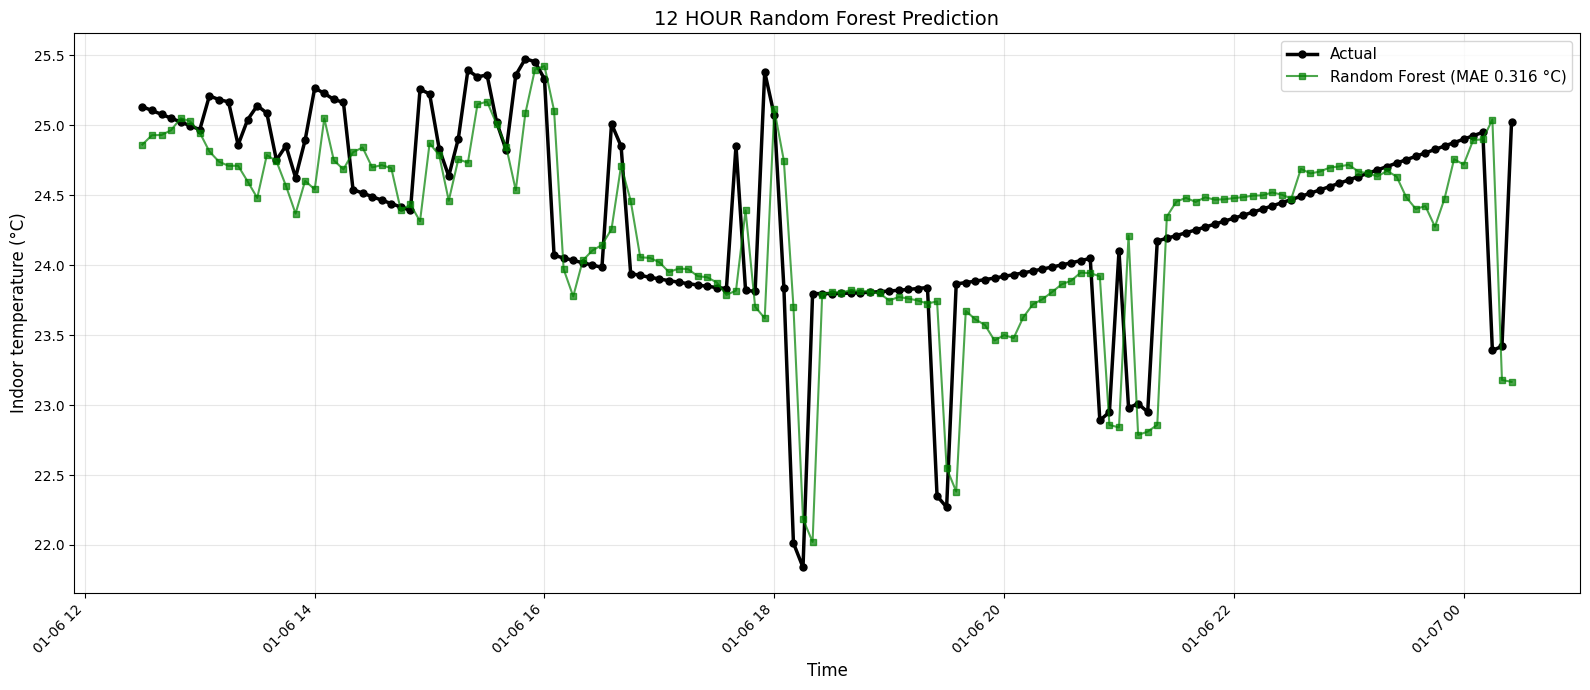

In [19]:
#randomforst model peramiters
rf_model = RandomForestRegressor(
    n_estimators=500,  
    max_depth=15,     
    min_samples_split=5,    
    min_samples_leaf=2,    
    max_features='sqrt',    
    bootstrap=True,    
    random_state=SEED,
    n_jobs=-1,       
    verbose=0
)

rf_model.fit(train_inputs_scaled, train_targets_np)

rf_pred_train = rf_model.predict(train_inputs_scaled)
rf_pred_test = rf_model.predict(test_inputs_scaled)


rf_mae_full = mean_absolute_error(test_targets_np, rf_pred_test)
rf_rmse_full = np.sqrt(mean_squared_error(test_targets_np, rf_pred_test))
rf_r2_full = r2_score(test_targets_np, rf_pred_test)
rf_train_mae = mean_absolute_error(train_targets_np, rf_pred_train)

print("\nrandomforst performance test set:")
print(f"train MAE {rf_train_mae:.4f} °C")
print(f"test MAE{rf_mae_full:.4f} °C")
print(f"test RMSE{rf_rmse_full:.4f} °C")
print(f"R² {max(-1, min(1, rf_r2_w)):.4f}")


# Calculate metrics for the specific window
window_size = min(WINDOW_SAMPLES, len(test_targets_np))

rf_mae_w = mean_absolute_error(test_targets_np[:window_size], rf_pred_test[:window_size])
rf_rmse_w = np.sqrt(mean_squared_error(test_targets_np[:window_size], rf_pred_test[:window_size]))
rf_r2_w = r2_score(test_targets_np[:window_size], rf_pred_test[:window_size])

print(f"\n{'Model':<18} {'MAE (°C)':<12} {'RMSE (°C)':<12} {'R²':<8}")
print(f"{'Random Forest':<18} {rf_mae_w:<12.4f} {rf_rmse_w:<12.4f} {max(-1, min(1, rf_r2_w)):.4f}")

y_true_w = test_targets_np[:window_size]
rf_pred_w = rf_pred_test[:window_size]
time_w = test_data["time"].iloc[1:window_size+1].values

plt.figure(figsize=(16, 7))
plt.plot(time_w, y_true_w, "o-", label="Actual", color="black", linewidth=2.5, markersize=5)
plt.plot(time_w, rf_pred_w, "s-", label=f"Random Forest (MAE {rf_mae_w:.3f} °C)", color="green", alpha=0.7, linewidth=1.5, markersize=4)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Indoor temperature (°C)", fontsize=12)
plt.title(f"{WINDOW_NAME.upper()} Random Forest Prediction", fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
